In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
import numpy as np
import glob

from sklearn.model_selection import train_test_split

#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

#datavis magic

plt.rcParams['figure.figsize'] = [15, 10]

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 23.7 ms


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/tmp'", use "location='/tmp'" instead.
  # This is added back by InteractiveShellApp.init_path()


In [193]:
#cohort import

os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'


final_pt_df2 = pd.read_csv(Path(wd + '/data/raw/csv/04042019_final_pt_df2_v.csv') , index_col=0) #only for patients with minimum vitals, 14478 icustay_id
patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 111 ms


In [194]:
len(patients)

11987

time: 2.57 ms


In [195]:

# # ##24 hr sensitivity
# # #importing in all clinical_variable files
# lower_window=0
# upper_window=1
# time_col="charttime"
# time_var="t_0"
# folder="24_hr_window"
# timewindowdays="24"
# date= '09062019'
# patient_df= final_pt_df2

# #48 hr sensitivity
# lower_window=0
# upper_window=2
# time_var="t_0"
# folder="48_hr_window"
# timewindowdays="48"
# date='16052019'
# time_col="charttime"
# time_var= 't_0'
# patient_df= final_pt_df2

#72 hr elixhauser-redo
date='11062019'
lower_window=0
upper_window=3
timewindowdays="72"
folder="{}_hr_window".format(timewindowdays)
time_col="charttime"
time_var= 't_0'
patient_df= final_pt_df2

os.chdir(r'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/')
big_df= pd.read_csv(Path(wd+'/data/processed/merged/{}_longdf_preImp_{}.csv'.format(date,timewindowdays),  index_col=0))
big_df= big_df.reset_index(drop=True).iloc[:,1:]

#quick housekeeping addition to accomidate older generated data
if len(big_df.loc[big_df['label']=="pao2/fio2",'label'])>1:
    big_df.loc[big_df['label']=="pao2/fio2",'label']="pao2fio2ratio"

time: 13.3 s


In [196]:
## last minute data cleaning/formatting

# #removing firstpos else neg ssc col
# big_df=big_df.loc[:,list(big_df.columns!="first_pos_else_neg_ssc")]
# #changing pao2/fio2 ratio label

len(big_df.loc[big_df['label']=="pao2/fio2",'label'])>1

False

time: 309 ms


In [197]:
#overview of all variables and formats
big_df.groupby('label')['value'].describe().sort_values('unique')

,count,unique,top,freq
label,,,,
leukocyte,14181,2,Neg/Not_tested,12042
vasopressin,17425,2,0.0,13778
rrt,14181,2,0.0,13018
phenylephrine,26338,2,1.0,14377
cancer_elix,14181,2,0.0,12439
o2_flow,14433,2,0.0,13442
norepinephrine,34103,2,1.0,22755
nitrite,14181,2,Neg/Not_tested,13783
dobutamine,15470,2,0.0,13951


time: 1.61 s


## initial data prep

In [198]:
#convert to two class

final_pt_df2['final_bin'].unique()
two_classes=['C_neg/A_partial','C_pos/A_full']
two_class_icu=final_pt_df2.loc[final_pt_df2.loc[:,"final_bin"].isin(two_classes),['icustay_id','subject_id','final_bin']]

time: 7.37 ms


In [199]:
big_df=big_df.loc[big_df['icustay_id'].isin(list(two_class_icu['icustay_id'])),:].copy()

time: 1.29 s


In [200]:
len(big_df)#7015776 -> ~3000000
big_df['icustay_id'].nunique() #14181 ->7588

7588

time: 30 ms


### roundabout way of sampling train/test set so that each subject is only in either train or test:

In [201]:
# label each subject_id with the max of the two classes. 
two_class_pt=two_class_icu.copy()
two_class_pt['final_bin']=pd.factorize(two_class_pt['final_bin'])[0]
two_class_maxsub=two_class_pt.loc[two_class_pt.groupby('subject_id')['final_bin'].idxmax(),:]

time: 1.49 s


In [202]:
# 70/30 train/test set split with 12345=seed, splitting on max final bin of each SUBJECT_ID
train, test = train_test_split(two_class_maxsub, test_size=0.3, random_state=12345, 
                               stratify=two_class_maxsub['final_bin'])
# generate list of each SUBJECT_ID in each split
train_subject=list(train['subject_id'])
test_subject=list(test['subject_id'])

#filtering big_df on train subjects and test subjects to get my train/test splits.
big_df_train= big_df.loc[big_df.loc[:,'subject_id'].isin(train_subject),:].copy()
big_df_test= big_df.loc[big_df.loc[:,'subject_id'].isin(test_subject),:].copy()
del big_df

time: 1.68 s


In [203]:
# #converting venttype to category
# big_df.loc[big_df.loc[:,'label']=='vent_recieved','value']= big_df.loc[big_df.loc[:,'label']=='vent_recieved','value'].astype('category')
# #big_df.loc[big_df.loc[:,'label']=='vent_recieved','value'].apply(astype('category'))
# big_df.loc[big_df.loc[:,'label']=='vent_recieved','value'] = pd.Categorical(big_df.loc[big_df.loc[:,'label']=='vent_recieved','value'])

time: 1.05 ms


In [204]:
def category_mapper(big_df):
    #converting categories to integers
    mapper={'Mech':2 , 'Oxygen': 1, 'None': 0}
    big_df.loc[big_df.loc[:,'label']=='vent_recieved','value']=big_df.loc[big_df.loc[:,'label']=='vent_recieved','value'].replace(mapper).copy()

    #gender_index=pd.factorize(big_df.loc[big_df.loc[:,'label']=='gender','value'])[1]
    mapper={'F':0 , 'M': 1}
    big_df.loc[big_df.loc[:,'label']=='gender','value']=big_df.loc[big_df.loc[:,'label']=='gender','value'].replace(mapper).copy()

    #leukocyte_index=pd.factorize(big_df.loc[big_df.loc[:,'label']=='leukocyte','value'])[1]
    mapper={'Neg/Not_tested':0 , 'pos': 1}
    big_df.loc[big_df.loc[:,'label']=='leukocyte','value']=big_df.loc[big_df.loc[:,'label']=='leukocyte','value'].replace(mapper).copy()
    #     pd.factorize(big_df.loc[big_df.loc[:,'label']=='leukocyte','value'])[0] 

    #nitrite_index=pd.factorize(big_df.loc[big_df.loc[:,'label']=='nitrite','value'])[1]
    mapper={'Neg/Not_tested':0 , 'pos': 1}
    big_df.loc[big_df.loc[:,'label']=='nitrite','value']=big_df.loc[big_df.loc[:,'label']=='nitrite','value'].replace(mapper).copy()
    #     pd.factorize(big_df.loc[big_df.loc[:,'label']=='nitrite','value'])[0] 
    
    
    # changing pao2/fio2 ratio to a category
    """
    A PaO2/FiO2 ratio less than or equal to 200 is necessary for the diagnosis of acute respiratory distress syndrome by the AECC criteria.[6] 
    The more recent Berlin criteria defines mild ARDS at a ratio of <300.

    A PaO2/FiO2 ratio less than or equal to 250 is one of the minor criteria for severe community acquired pneumonia (i.e., possible indication for inpatient treatment).

    A PaO2/FiO2 ratio less than or equal to 333 is one of the variables in the SMART-COP risk score for intensive respiratory or vasopressor support in community-acquired pneumonia.
    """

    
    pd.to_numeric(big_df[big_df['label']=="pao2fio2ratio"]['value'])
    labels= ['0-200', '201-333', "334-475","476+"]
    bins = pd.IntervalIndex.from_tuples([(0, 200), (200, 333), (333, 475),(475,3000)])

    big_df.loc[big_df['label']=="pao2fio2ratio",'value']=pd.cut(pd.to_numeric(big_df.loc[big_df['label']=="pao2fio2ratio",'value']), bins,right=False, labels=labels)
    big_df.loc[big_df['label']=="pao2fio2ratio",'value'].value_counts()

    
    return(big_df)


time: 124 ms


In [205]:
big_df_train=category_mapper(big_df_train)
big_df_test=category_mapper(big_df_test)

time: 3.73 s


## calc median/iqr for standardization
take all non-categorical variables for HEALTHY PATIENTS and calculate the median and IQR for them. then will use this to make z scores via: x-median/IQR

### june 13: changed sparse to catgorical

In [213]:
continuous=['daily_sofa',
            'lactate',
            'mingcs',
            'diasbp',
            'heartrate',
            'meanartpress',
            'resprate',
            'sysbp',
            'temperature',
            'hemoglobin',
            'platelet',
            'wbc',
            'calcium',
            'glucose',
            'ph',
            'bicarbonate',
            'bun',
            'chloride',
            'creatinine',
            'inr',
            'potassium',
            'ptt',
            'sodium',
            'bilirubin',
            'spo2',
            'sum_elix']


onetime=['first_admit_age','height','weight']

vaso_active=['phenylephrine',
            'norepinephrine',
            'vasopressin',
            'dobutamine',
            'dopamine',
            'epinephrine'] 

ordinal=[
            'leukocyte',
            'nitrite',
            'vent_recieved',
            'o2_flow',
            'rrt',
            'pao2fio2ratio',
            'cancer_elix',
            "any_vasoactives",
            'bands', #added 6/13/19
            'pco2' #added 6/13/19
]

categorical=[
            "ethnicity",
            'gender'
]


time: 20 ms


In [214]:
def median_label_fxn(big_df):
    global final_pt_df2
    
    healthy_pt=list(final_pt_df2[final_pt_df2['final_bin']=="C_neg/A_partial"]['icustay_id'])

    #filter to only healthy patients filter
    ##splitting big_df, making a copy and restricting it to all values that will be usd in standardizing
    healthy_df=big_df[big_df['label'].isin(continuous+onetime)].copy()
    healthy_df['value']= pd.to_numeric(healthy_df['value']) #converting to numeric 
    healthy_df=healthy_df[healthy_df['icustay_id'].isin(healthy_pt)].copy() #only numerical values for cneg/ab partial pt
    
    #finding the last 24 hours of each healthy patient.
    healthy_pt_end=pd.DataFrame(healthy_df.groupby("icustay_id")['delta'].max())
    healthy_pt_end["start"]=healthy_pt_end['delta']- pd.to_timedelta("1 day 00:00:00")
    healthy_pt_end=healthy_pt_end.rename(columns={"delta":"end"}).reset_index()
    healthy_df= pd.merge(healthy_df,healthy_pt_end, left_on="icustay_id", right_on="icustay_id", how="left" ) #now have the last 24 hours annotated for each patient as start and end.
    
    #calculating medians and iqr for each label based on healthy patient's last 24 hours in icu
    median_label=pd.DataFrame((healthy_df.groupby("label")['value'].median())).reset_index()
    median_label=median_label.rename(columns={'value':"median"})
    iqr_label=pd.DataFrame((healthy_df.groupby("label")['value'].quantile(0.75)-healthy_df.groupby("label")['value'].quantile(0.25))).reset_index()
    iqr_label=iqr_label.rename(columns={'value':"iqr"})
    median_label=pd.merge(median_label,iqr_label)  #final median df
    return(median_label)

def combine_vasoactives(big_noCat, median_label):
    global vaso_active
    ##combining vasoactives
    vaso_active_df=big_noCat[big_noCat['label'].isin(vaso_active)].groupby('icustay_id')['value'].max().reset_index()
    vaso_active_df['uom']="y/n"
    vaso_active_df['label']="any_vasoactives"
    vaso_active_df['delta']=pd.to_timedelta("0days")
    vaso_active_df['source']="any_vasoactives"

    vaso_active_df=pd.merge(vaso_active_df, final_pt_df2[["icustay_id",'subject_id',"t_0"]], how="left", left_on="icustay_id", right_on="icustay_id")
    vaso_active_df=pd.merge(vaso_active_df, median_label, how="left").fillna(0)
    vaso_active_df['standardize']=vaso_active_df['value']
    vaso_active_df['raw_value']=vaso_active_df['value']
    vaso_active_df.head()

    # # #grabing the rest of the variables not suitable for range or mean/std
    big_noCat=pd.concat([big_noCat, vaso_active_df], sort=False)
    return(big_noCat)

def standardization_fxn(big_df):
    global continuous, onetime, vaso_active, ordinal, categorical
    
    median_label=median_label_fxn(big_df)
    median_label
    median_label_nocat=median_label.loc[median_label.loc[:,'label'].isin(continuous),:].copy()
    median_label_cat=median_label.loc[median_label.loc[:,'label'].isin(continuous),:].copy()
    
    ### dataformatting: convert all dtypes to a numeric type that pereserves nan. 
    #splitting categorical, ordinal and continuous
    big_categorical= big_df.loc[big_df.loc[:,'label'].isin(categorical),:].copy() 

    #continuous and ordinal variables
    big_noCat= big_df.loc[big_df.loc[:,'label'].isin(continuous),:].copy() 
    big_noCat['value']= big_noCat['value'].apply(pd.to_numeric, args=('coerce',)) #instead of convert to float, may preserve nan's better. 
    
    ### adding a standardized value (x-median)/iqr  where median is of the last 24 hours in time window for culture neg/ ab partial patients 
    big_noCat=pd.merge(big_noCat, median_label, how="left") 
    #loging values
    big_noCat['median']= np.log(big_noCat['median']+1.0)
    big_noCat['iqr']= np.log(big_noCat['iqr']+1.0)
    big_noCat['raw_value']=big_noCat['value']
    big_noCat['value']=np.log(big_noCat['value']+1.0)
    
    big_noCat['standardize']=((big_noCat['value']-big_noCat['median'])/big_noCat['iqr']).fillna(0) #standardize is log standardized

    #making an ordinal df to concat on
    ord_df=big_df.loc[big_df.loc[:,'label'].isin(ordinal+vaso_active),:].copy()
    ord_df['raw_value']=ord_df['value']
    ord_df['standardize']=ord_df['value']
    ord_df['median']=None
    ord_df['iqr']=None

    big_noCat=pd.concat([big_noCat,ord_df], sort=False)
    
    #making all ordinal values in standardize equal to unstandardized
    big_noCat.loc[big_noCat['label'].isin(ordinal+vaso_active),'standardize']=big_noCat.loc[big_noCat['label'].isin(ordinal+vaso_active),'value']  #do i need to add sparse?
    #ig_noCat.head()
    
    big_noCat['standardize']= big_noCat['standardize'].apply(pd.to_numeric, args=('coerce',)) #errors occuring downstream due to not having numeric, trying this 4/18/19
    
    ##last step, combining vasoactives into 1 feature
    big_noCat=combine_vasoactives(big_noCat, median_label)  

    return(big_noCat, big_categorical)

time: 394 ms


In [233]:
median_label_fxn(big_df_train)

,label,median,iqr
0,bicarbonate,24.000000,5.000000
1,bilirubin,0.800000,1.700000
2,bun,20.000000,21.000000
3,calcium,1.130000,0.100000
4,chloride,105.000000,8.000000
5,creatinine,1.000000,0.900000
6,daily_sofa,3.000000,4.000000
7,diasbp,59.000000,18.000000
8,first_admit_age,65.370000,26.080000
9,glucose,127.000000,56.000000


time: 4.54 s


In [492]:

##standardizing and train/test splitting data

noCat_df_train, cat_df_train = standardization_fxn(big_df_train)
noCat_df_train['delta']= pd.to_timedelta(noCat_df_train['delta'])

noCat_df_test, cat_df_test = standardization_fxn(big_df_test)
noCat_df_test['delta']= pd.to_timedelta(noCat_df_test['delta'])

#fixing one patient with delta=4 sofa
noCat_df_train.loc[noCat_df_train['delta']==pd.Timedelta("4 days"), 'delta']=pd.Timedelta("3 days")
#fixing one patient with delta=4 sofa
noCat_df_test.loc[noCat_df_test['delta']==pd.Timedelta("4 days"), 'delta']=pd.Timedelta("3 days")

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.


time: 2min 19s


In [216]:
noCat_df_train.head()

,icustay_id,uom,label,value,t_0,delta,source,subject_id,median,iqr,raw_value,standardize
0,200030.0,daily_sofa_score,daily_sofa,1.09861,2150-11-14,0 days 00:00:00.000000000,sofa,14987,1.38629,1.60944,2,-0.178747
1,200030.0,mmHg,diasbp,4.17439,2150-11-14,0 days 00:00:00.000000000,vitals,14987,4.09434,2.94444,64,0.0271844
2,200030.0,mmHg,diasbp,4.09434,2150-11-14,0 days 00:00:00.000000000,vitals,14987,4.09434,2.94444,59,0
3,200030.0,NaN,glucose,5.32301,2150-11-14,0 days 00:00:00.000000000,vitals,14987,4.85203,4.04305,204,0.116491
4,200030.0,bpm,heartrate,4.57471,2150-11-14,0 days 00:00:00.000000000,vitals,14987,4.45435,3.17805,96,0.0378734


time: 17.6 ms


In [364]:
noCat_df_train[noCat_df_train['label']=='sum_elix']

,icustay_id,uom,label,value,t_0,delta,source,subject_id,median,iqr,raw_value,standardize
9,200030.0,elixhauser_comorb_sum,sum_elix,0,2150-11-14,0 days,sum_elix,14987,0,1.38629,0,0
610,200033.0,elixhauser_comorb_sum,sum_elix,0,2198-08-11,0 days,sum_elix,56369,0,1.38629,0,0
1230,200036.0,elixhauser_comorb_sum,sum_elix,0,2181-08-27,0 days,sum_elix,9960,0,1.38629,0,0
1608,200061.0,elixhauser_comorb_sum,sum_elix,0,2134-01-24,0 days,sum_elix,74282,0,1.38629,0,0
1918,200063.0,elixhauser_comorb_sum,sum_elix,0,2141-03-12,0 days,sum_elix,99052,0,1.38629,0,0
2727,200075.0,elixhauser_comorb_sum,sum_elix,0,2159-09-24,0 days,sum_elix,67800,0,1.38629,0,0
2942,200078.0,elixhauser_comorb_sum,sum_elix,0,2131-08-02,0 days,sum_elix,27961,0,1.38629,0,0
2943,200078.0,elixhauser_comorb_sum,sum_elix,1.38629,2131-08-02,0 days,sum_elix,27961,0,1.38629,3,1
3106,200091.0,elixhauser_comorb_sum,sum_elix,0,2185-08-15,0 days,sum_elix,31854,0,1.38629,0,0
3693,200108.0,elixhauser_comorb_sum,sum_elix,1.79176,2110-12-10,0 days,sum_elix,50772,0,1.38629,5,1.29248


time: 150 ms


In [235]:
len(noCat_df_train['label'].unique()) #42, should be 28

42

time: 95.5 ms


In [217]:
noCat_df_train['icustay_id'].unique()[1]

200033.0

time: 37.3 ms


In [491]:
#fixing one patient with delta=4 sofa
noCat_df_train.loc[noCat_df_train['delta']==pd.Timedelta("4 days"), 'delta']=pd.Timedelta("3 days")
#fixing one patient with delta=4 sofa
noCat_df_test.loc[noCat_df_test['delta']==pd.Timedelta("4 days"), 'delta']=pd.Timedelta("3 days")

time: 857 ms


# messing with timeseries vis
* resampling different time windows
* forward fill 
* cat vs nocat
* visualization

In [221]:
noCat_df_train['delta'].describe()

count                   2412975
mean     1 days 04:36:55.890392
std      0 days 19:57:13.453162
min             0 days 00:00:00
25%             0 days 12:00:00
50%             1 days 02:00:00
75%             1 days 20:00:00
max             4 days 00:00:00
Name: delta, dtype: object

time: 111 ms


In [222]:
#trying to find a patient without a 0:00:00 and 3day time
noCat_df_train.loc[(noCat_df_train.loc[:,'icustay_id']==noCat_df_train['icustay_id'].unique()[5]),['delta']].describe()

,delta
count,232
mean,0 days 16:21:35.689655
std,0 days 15:41:56.585486
min,0 days 00:00:00
25%,0 days 04:00:00
50%,0 days 14:23:00
75%,0 days 23:00:00
max,2 days 16:44:00


time: 34.9 ms


In [223]:
(noCat_df_train.groupby('icustay_id')['delta'].min()).min()
#Good news, everyone has atleast a 0:00:00 timepoint

Timedelta('0 days 00:00:00')

time: 44.4 ms


In [224]:
(noCat_df_train.groupby('icustay_id')['delta'].max()).min()
#but not everyone has a 3day timepoint.

Timedelta('0 days 14:00:00')

time: 48.3 ms


### trying to pivot table before any resample

In [102]:
#one patient and all variable
test_df1=noCat_df_train.loc[(noCat_df_train.loc[:,'icustay_id']==200030.0),['delta','value','label']].copy()

#one patient and one variable
test_df2=noCat_df_train.loc[(noCat_df_train.loc[:,'label']=='diasbp')&(noCat_df_train.loc[:,'icustay_id']==200030.0),['delta','value']].copy()

hourly=test_df2.set_index('delta').resample("H").max().fillna(method="ffill") #max and 
#hourly=test_df2.resample("H",on='delta').count() #same as above but don't need to set delta to index.

time: 143 ms


In [103]:
test_df1.head()

,delta,value,label
0,0 days,1.09861,daily_sofa
1,0 days,4.17439,diasbp
2,0 days,4.09434,diasbp
3,0 days,5.32301,glucose
4,0 days,4.57471,heartrate


time: 6.73 ms


In [98]:
test_df2.head()

,delta,value
1,00:00:00,4.17439
2,00:00:00,4.09434
12,01:00:00,4.20469
19,02:00:00,4.12713
20,02:00:00,4.14313


time: 6.29 ms


In [99]:
hourly.head()

,value
delta,
00:00:00,4.174387
01:00:00,4.204693
02:00:00,4.143135
03:00:00,4.219508
04:00:00,4.189655


time: 7.44 ms


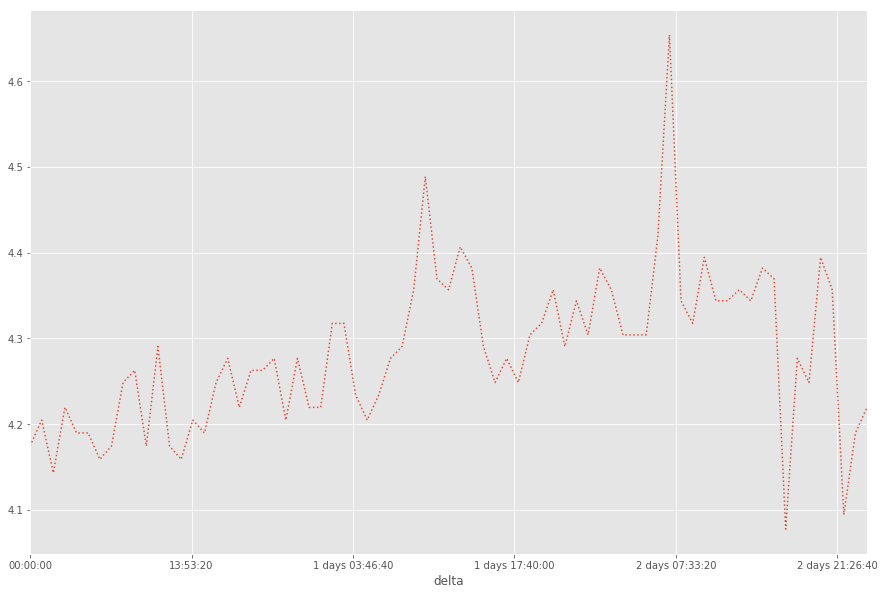

time: 226 ms


In [89]:
hourly['value'].plot(style=[':','--','-']) #work

### step2: write fxn to standardize timeframe to 0:00:00 to 2days 23:00:00 for hourly after resampling. (this code isn't used in final). 

In [93]:
def timeframe_fix_fxn(df):
    """
    this fxn appends a starting and ending time onto dataframe.
    df is a dataframe with delta and value for a specific label.
    """
    ##don't need this because eveyrone has atleast 1 0:00:00 timepoint.
#     #adding in start time of 0:00:00: 
#     ##making a df with 0:00 timedelta with none value and appending this to first row
#     if (df.sort_values("delta")['delta'].iloc[0] != pd.Timedelta("00:00:00")):
#         df2=pd.DataFrame([[pd.Timedelta('00:00:00'),None]], columns=['delta','value'])
#         df=df.append(df2) 
#         ##alternative way of doing it:
# #         df.loc[-1] = [pd.Timedelta("00:00:00"), None]  # adding a row
# #         df.index = df.index + 1  # shifting index
# #         df = df.sort_index()  # sorting by index
#     else:
#         pass
    
    #adding in end time of '2 days 23:00:00'
    if (df.sort_values("delta")['delta'].iloc[-1] != pd.Timedelta('3 days 00:00:00')):
        df3=pd.DataFrame([[pd.Timedelta('3 days 00:00:00'),None]], columns=['delta','value'])
        df=df.append(df3)
    else:
        pass
    
    df= df.sort_values('delta')
    return(df)


time: 17.2 ms


In [94]:
#adding start and endtime if not already there. works for single variable and single patient.
test_df3=timeframe_fix_fxn(test_df2) #adding on 0:00:00 start and 2day 23:00:00 end. 

time: 5.8 ms


In [95]:
test_df3.head()

,delta,value
1,00:00:00,4.17439
2,00:00:00,4.09434
12,01:00:00,4.20469
19,02:00:00,4.12713
20,02:00:00,4.14313


time: 6.37 ms


### problem: only works for single variable, doesn't work with many variables.
### solution: i'll just add a delta value to the initial dataset. (currently only works for this single patient, need to expand if i go to all patients)
note, by adding a Null bicarbonate value at t_0+72 it records a value there and is thus is used as the endpoint to the resampling fxn. if there is infact a value there, then it will be taken instead of the null (due to the max fxn). 

In [106]:
# #adding a row with null values and final timepoint
# df= pd.DataFrame(test_df1.iloc[-1].T)
# df.iloc[:,0]=None
# df=pd.DataFrame(df).T
# df['delta']=pd.Timedelta("2 days 23:00:00")
# df['label']="bicarbonate"

# test_df=test_df1.append(df)

time: 8.5 ms


In [109]:
# test_df1['delta'].describe()

count                       631
mean     1 days 10:28:41.458003
std      0 days 22:47:35.947002
min             0 days 00:00:00
25%             0 days 15:00:00
50%             1 days 08:00:00
75%             2 days 06:00:00
max             3 days 00:00:00
Name: delta, dtype: object

time: 6.86 ms


In [133]:
noCat_df_train[noCat_df_train['label']=='bicarbonate'].head(2)

,icustay_id,uom,label,value,t_0,delta,source,subject_id,median,iqr,raw_value,standardize
30,200030.0,mEq/L,bicarbonate,2.99573,2150-11-14,02:46:00,labs,14987,3.21888,1.79176,19,-0.124539
144,200030.0,mEq/L,bicarbonate,2.94444,2150-11-14,15:10:00,labs,14987,3.21888,1.79176,18,-0.153166


time: 126 ms


In [326]:
#first getting a row with bicarbonate from noCat_df
bicarb=noCat_df_train.loc[noCat_df_train['label']=='bicarbonate',:].head(1)

#making a df for each icustay and adding appropriate values for a 3day final timepoint with None values.
df= pd.DataFrame(noCat_df_train.drop_duplicates('icustay_id'))#.iloc[-1].T)

df['uom']=bicarb['uom'].values[0]
df['label']=bicarb['label'].values[0]
df['value']=None
df['delta']=pd.Timedelta("3 days")
df['source']=bicarb['source'].values[0]
df['median']=bicarb['median'].values[0]
df['iqr']=bicarb['iqr'].values[0]
df['raw_value']=None
df['standardize']=None
#df

# appending this onto nocat dataset with ONLY continuous (removed ordinal)
noCat_df_train2= noCat_df_train[noCat_df_train['label'].isin(continuous)].copy()
noCat_df_train2=noCat_df_train2.append(df)

#testing the minimum  of all icustays max deltas. 
(noCat_df_train2.groupby('icustay_id')['delta'].max()).min()

Timedelta('3 days 00:00:00')

time: 2.99 s


In [237]:
noCat_df_train2['icustay_id'].nunique() #2418291 rows.
#5316 icustay_ids

5316

time: 20.9 ms


In [238]:
noCat_df_train2.head()

,icustay_id,uom,label,value,t_0,delta,source,subject_id,median,iqr,raw_value,standardize
0,200030.0,daily_sofa_score,daily_sofa,1.09861,2150-11-14,0 days,sofa,14987,1.38629,1.60944,2,-0.178747
1,200030.0,mmHg,diasbp,4.17439,2150-11-14,0 days,vitals,14987,4.09434,2.94444,64,0.0271844
2,200030.0,mmHg,diasbp,4.09434,2150-11-14,0 days,vitals,14987,4.09434,2.94444,59,0
3,200030.0,NaN,glucose,5.32301,2150-11-14,0 days,vitals,14987,4.85203,4.04305,204,0.116491
4,200030.0,bpm,heartrate,4.57471,2150-11-14,0 days,vitals,14987,4.45435,3.17805,96,0.0378734


time: 14.5 ms


In [468]:
noCat_df_train2['label'].unique()

array(['daily_sofa', 'diasbp', 'glucose', 'heartrate', 'meanartpress',
       'resprate', 'spo2', 'sum_elix', 'sysbp', 'temperature',
       'bicarbonate', 'bun', 'chloride', 'creatinine', 'hemoglobin',
       'inr', 'platelet', 'potassium', 'ptt', 'sodium', 'wbc', 'calcium',
       'lactate', 'ph', 'bilirubin', 'mingcs'], dtype=object)

time: 103 ms


### step3: visualize the resampled variables for a single patient

In [286]:
maxCol=lambda x: max(x.min(), x.max(), key=abs)
#df.apply(maxCol,axis=1)

time: 1.49 ms


In [469]:
grouper = noCat_df_train2[['delta','standardize','label','icustay_id']].groupby(['icustay_id',pd.Grouper(key="delta",freq='4H'), 'label'])


time: 907 ms


In [470]:
grouper['standardize'].apply(maxCol).unstack(["label"]).head(5)

KeyboardInterrupt: 

time: 17.6 s


In [184]:
#grouper['standardize'].max().unstack(["label"]).isna().sum()

label
any_vasoactive    73177
bands             73177
bicarbonate       56956
bilirubin         72648
bun               56851
calcium           70273
cancer_elix       73177
chloride          55703
creatinine        56779
daily_sofa        66148
diasbp            12872
dobutamine        73021
dopamine          72588
epinephrine       72890
glucose           33624
heartrate         11709
hemoglobin        57956
inr               65504
lactate           69526
leukocyte         73177
meanartpress      12630
mingcs            75895
nitrite           73177
norepinephrine    70257
o2_flow           73121
pao2fio2ratio     73177
pco2              73177
ph                62836
phenylephrine     71266
platelet          58630
potassium         52067
ptt               64954
resprate          12177
rrt               73177
sodium            55046
spo2              12482
sum_elix          73177
sysbp             12866
temperature       19590
vasopressin       72661
vent_recieved     73235
wbc       

time: 1min 31s


In [285]:
#test_unstacked=grouper['standardize'].max().unstack("label")

time: 1min 29s


In [471]:
test_unstacked=grouper['standardize'].apply(maxCol).unstack("label")

KeyboardInterrupt: 

time: 18.5 s


In [291]:
test_unstacked.head(19) #19 delta values

label                       bicarbonate  bilirubin       bun   calcium  \
icustay_id delta                                                         
200030.0   0 days 00:00:00    -0.124539        NaN  0.104422  0.098057   
           0 days 04:00:00          NaN        NaN       NaN       NaN   
           0 days 08:00:00          NaN        NaN       NaN       NaN   
           0 days 12:00:00    -0.153166        NaN  0.081304       NaN   
           0 days 16:00:00          NaN        NaN       NaN       NaN   
           0 days 20:00:00          NaN        NaN       NaN       NaN   
           1 days 00:00:00    -0.153166        NaN  0.043199       NaN   
           1 days 04:00:00          NaN        NaN       NaN       NaN   
           1 days 08:00:00          NaN        NaN       NaN       NaN   
           1 days 12:00:00          NaN        NaN       NaN       NaN   
           1 days 16:00:00          NaN        NaN       NaN       NaN   
           1 days 20:00:00          NaN        NaN       NaN       NaN   
           2 days 00:00:00    -0.183342        NaN  0.015050       NaN   
           2 days 04:00:00          NaN        NaN       NaN       NaN   
           2 days 08:00:00          NaN        NaN       NaN       NaN   
           2 days 12:00:00          NaN        NaN       NaN       NaN   
           2 days 16:00:00          NaN        NaN       NaN       NaN   
           2 days 20:00:00          NaN   2.167681       NaN  0.941623   
           3 days 00:00:00          NaN        NaN       NaN       NaN   

label                       chloride  creatinine  daily_sofa    diasbp  \
icustay_id delta                                                         
200030.0   0 days 00:00:00  0.025059    0.000000   -0.178747  0.042508   
           0 days 04:00:00       NaN         NaN         NaN  0.032370   
           0 days 08:00:00       NaN         NaN         NaN  0.066605   
           0 days 12:00:00  0.020977   -0.079914         NaN  0.037477   
           0 days 16:00:00       NaN         NaN         NaN  0.061921   
           0 days 20:00:00       NaN         NaN         NaN  0.061921   
           1 days 00:00:00  0.025059   -0.079914   -0.861353  0.075785   
           1 days 04:00:00       NaN         NaN         NaN  0.061921   
           1 days 08:00:00       NaN         NaN         NaN  0.133911   
           1 days 12:00:00       NaN         NaN         NaN  0.106090   
           1 days 16:00:00       NaN         NaN         NaN  0.071226   
           1 days 20:00:00       NaN         NaN         NaN  0.089105   
           2 days 00:00:00  0.020977   -0.164150    0.138647  0.097704   
           2 days 04:00:00       NaN         NaN         NaN  0.190059   
           2 days 08:00:00       NaN         NaN         NaN  0.101923   
           2 days 12:00:00       NaN         NaN         NaN  0.097704   
           2 days 16:00:00       NaN         NaN         NaN  0.093431   
           2 days 20:00:00       NaN         NaN         NaN  0.101923   
           3 days 00:00:00       NaN         NaN    0.251930  0.042508   

label                        glucose  heartrate  ...  platelet  potassium  \
icustay_id delta                                 ...                        
200030.0   0 days 00:00:00  0.154446   0.053689  ... -0.024085  -0.379634   
           0 days 04:00:00  0.055192   0.062810  ...       NaN        NaN   
           0 days 08:00:00 -0.026489   0.094159  ...       NaN        NaN   
           0 days 12:00:00  0.032544   0.107438  ...       NaN  -0.466899   
           0 days 16:00:00 -0.076362   0.132424  ...       NaN        NaN   
           0 days 20:00:00  0.061299   0.132424  ...       NaN        NaN   
           1 days 00:00:00 -0.063544   0.112596  ... -0.011116  -0.217483   
           1 days 04:00:00  0.085694   0.120179  ...       NaN        NaN   
           1 days 08:00:00  0.044127   0.099538  ...       NaN        NaN   
           1 days 12:00:00       NaN   0.10

time: 34.5 ms


In [ ]:
##takes 10 minutes to run, resamples the data in 4 hour blocks and puts na for values unfilled. every icustay_id now has a row for every 4 hour block. 
restacked=test_unstacked.groupby('icustay_id').resample('4H',level=-1).apply(maxCol) #level =-1 : corresponds to the delta multiindex. 

In [ ]:
restacked_ffilled=restacked.groupby('icustay_id').fillna(method='ffill') #fills in na using feed forward. 
##issue is, if there is no value previously seen, then na still exists. for these na before a value is seen, a 0 is filled in, to represent healthy median value. 
restacked_ffilled=restacked_ffilled.fillna(0)# 

In [368]:
-restacked_ffilled.head()

label                bicarbonate  bilirubin       bun   calcium  chloride  \
icustay_id delta                                                            
200030.0   00:00:00    -0.124539        0.0  0.104422  0.098057  0.025059   
           04:00:00    -0.124539        0.0  0.104422  0.098057  0.025059   
           08:00:00    -0.124539        0.0  0.104422  0.098057  0.025059   
           12:00:00    -0.153166        0.0  0.081304  0.098057  0.020977   
           16:00:00    -0.153166        0.0  0.081304  0.098057  0.020977   

label                creatinine  daily_sofa    diasbp   glucose  heartrate  \
icustay_id delta                                                             
200030.0   00:00:00    0.000000   -0.178747  0.042508  0.154446   0.053689   
           04:00:00    0.000000   -0.178747  0.032370  0.055192   0.062810   
           08:00:00    0.000000   -0.178747  0.066605 -0.026489   0.094159   
           12:00:00   -0.079914   -0.178747  0.037477  0.032544   0.107438   
           16:00:00   -0.079914   -0.178747  0.061921 -0.076362   0.132424   

label                ...  platelet  potassium       ptt  resprate    sodium  \
icustay_id delta     ...                                                      
200030.0   00:00:00  ... -0.024085  -0.379634 -0.064347  0.126171  0.003972   
           04:00:00  ... -0.024085  -0.379634 -0.064347 -0.050668  0.003972   
           08:00:00  ... -0.024085  -0.379634 -0.064347  0.126171  0.003972   
           12:00:00  ... -0.024085  -0.466899 -0.064347  0.107309  0.007917   
           16:00:00  ... -0.024085  -0.466899 -0.064347  0.194988  0.007917   

label                    spo2  sum_elix     sysbp  temperature       wbc  
icustay_id delta                                                          
200030.0   00:00:00 -0.012811       0.0  0.059001     0.022374  0.161889  
           04:00:00 -0.019318       0.0  0.050986    -0.008226  0.161889  
           08:00:00 -0.019318       0.0  0.042741    -0.004107  0.161889  
           12:00:00 -0.019318       0.0  0.011876     0.008178  0.161889  
           16:00:00 -0.025893       0.0  0.050986     0.014279  0.161889  

[5 rows x 26 columns]

time: 24.2 ms


In [355]:
###code graveyard

# #test_unstacked.reset_index().groupby('icustay_id').resample("4H").max().fillna(method='ffill')
# #test_unstacked.groupby(pd.Grouper(freq='4H', level=1)).max()
# #test_unstacked.loc[299914.0,:]#.groupby(['icustay_id',pd.Grouper(pd.Grouper(freq='4H', level=1))])
# #test_unstacked.groupby(['icustay_id',pd.Grouper(freq='4H', level=-1)]).resample("4H").max().fillna(method='ffill')#.max()

# # def using_reset_index(df):
# #     df = df.reset_index(level=[0, 1])
# #     return df.groupby(['icustay_id','delta']).resample('4H').max().fillna(method='ffill').max()

# #test_unstacked.reset_index(level=[0, 1]).groupby('icustay_id').resample

# #test_unstacked.groupby('icustay_id').resample('4H',level=-1).max().fillna(method='ffill').max()

# #test_unstacked.groupby('icustay_id').resample('4H',level=-1).apply(maxCol).fillna(method='ffill').apply(maxCol)

# ##takes 10 minutes to run, resamples the data in 4 hour blocks and 
# restacked=test_unstacked.groupby('icustay_id').resample('4H',level=-1).apply(maxCol) #level =-1 : corresponds to the delta multiindex. 


# #.apply(maxCol)

# #using_reset_index(test_unstacked)
# #test_unstacked.resample("4H").max().fillna(method='ffill')#.max()

time: 11min 34s


## now need to turn into a tensor and get a y label for each icustay_id.
* [samples, timesteps, features]: 5316, 26, 19

In [434]:
m,n = len(restacked_ffilled.index.levels[0]), len(restacked_ffilled.index.levels[1])
xtrain = restacked_ffilled.values.reshape(m,n,-1).swapaxes(1,2)

time: 20.8 ms


In [441]:
xtrain.shape

(5316, 19, 26)

time: 2.31 ms


In [451]:
np.save("rnn/lstm_xtrain", xtrain, allow_pickle=True, fix_imports=True)
np.save("rnn/lstm_ytrain", ytrain, allow_pickle=True, fix_imports=True)

time: 247 ms


# wrapping it all in functions

In [486]:
def prep_for_resample(noCat_df):
    #first getting a row with bicarbonate from noCat_df
    bicarb=noCat_df.loc[noCat_df['label']=='bicarbonate',:].head(1)

    #making a df for each icustay and adding appropriate values for a 3day final timepoint with None values.
    df= pd.DataFrame(noCat_df.drop_duplicates('icustay_id'))#.iloc[-1].T)

    df['uom']=bicarb['uom'].values[0]
    df['label']=bicarb['label'].values[0]
    df['value']=None
    df['delta']=pd.Timedelta("3 days")
    df['source']=bicarb['source'].values[0]
    df['median']=bicarb['median'].values[0]
    df['iqr']=bicarb['iqr'].values[0]
    df['raw_value']=None
    df['standardize']=None

    # appending this onto nocat dataset with ONLY continuous (removed ordinal)
    noCat_df= noCat_df[noCat_df['label'].isin(continuous)].copy()
    noCat_df=noCat_df.append(df)
    return(noCat_df)

def resampler(df2):
    maxCol=lambda x: max(x.min(), x.max(), key=abs)
    
    grouper = df2[['delta','standardize','label','icustay_id']].groupby(['icustay_id',pd.Grouper(key="delta",freq='4H'), 'label'])
    test_unstacked=grouper['standardize'].apply(maxCol).unstack("label")

    ##takes 10 minutes to run, resamples the data in 4 hour blocks and puts na for values unfilled. every icustay_id now has a row for every 4 hour block. 
    restacked=test_unstacked.groupby('icustay_id').resample('4H',level=-1).apply(maxCol) #level =-1 : corresponds to the delta multiindex. 

    restacked_ffilled=restacked.groupby('icustay_id').fillna(method='ffill') #fills in na using feed forward. 
    ##issue is, if there is no value previously seen, then na still exists. for these na before a value is seen, a 0 is filled in, to represent healthy median value. 
    restacked_ffilled=restacked_ffilled.fillna(0)# 
    
    return(restacked_ffilled)


time: 79.8 ms


In [691]:
def main(test):
    if test==True:
        df2=prep_for_resample(noCat_df_test)    
        restacked_df=resampler(df2)
        
        m,n = len(restacked_df.index.levels[0]), len(restacked_df.index.levels[1]) #(n_patients, n_timepoints)
        x_test = restacked_df.values.reshape(m,n,-1)#restacked_ffilled_df2.values.reshape(m,-1,n)#.swapaxes(1,2)
        
        #
        y_test= pd.merge(pd.DataFrame({'icustay_id':restacked_df.index.levels[0]}), final_pt_df2[['icustay_id','final_bin']])
        y_test.loc[y_test['final_bin']=='C_pos/A_full','final_bin']=1
        y_test.loc[y_test['final_bin']=='C_neg/A_partial','final_bin']=0
        y_test=y_test['final_bin'].values
        
        return(restacked_df, x_test, y_test)

    else:
        df2=prep_for_resample(noCat_df_train)    
        restacked_df=resampler(df2)
        
        
        train_patients=final_pt_df2.loc[final_pt_df2.loc[:,"subject_id"].isin(train_subject),['icustay_id','subject_id','final_bin']]
        train_patients['final_bin']=pd.factorize(train_patients['final_bin'])[0]
        train_patients_maxsub=train_patients.loc[train_patients.groupby('subject_id')['final_bin'].idxmax(),:]

        # 70/30 train/test set split with 12345=seed, splitting on max final bin of each SUBJECT_ID
        train_val, val = train_test_split(train_patients_maxsub, test_size=0.2, random_state=12345, 
                                       stratify=train_patients_maxsub['final_bin'])
        # generate list of each SUBJECT_ID in each split
        train_val_subject=list(train_val['subject_id'])
        val_subject=list(val['subject_id'])

        train_val_icu=list(two_class_icu.loc[two_class_icu['subject_id'].isin(train_val_subject),'icustay_id'] )
        val_icu=list(two_class_icu.loc[two_class_icu['subject_id'].isin(val_subject),'icustay_id'] )
        # # #filtering big_df on train subjects and test subjects to get my train/test splits.
        restacked_train= restacked_df[restacked_df.index.get_level_values('icustay_id').isin(train_val_icu)]
        restacked_val= restacked_df[restacked_df.index.get_level_values('icustay_id').isin(val_icu)]

        ###filtering x
        m,n = restacked_train.reset_index()['icustay_id'].nunique(), restacked_train.reset_index()['delta'].nunique() #(n_patients, n_timepoints)
        x_train = restacked_train.values.reshape(m,n,-1)#restacked_ffilled_df2.values.reshape(m,-1,n)#.swapaxes(1,2)

        m,n = restacked_val.reset_index()['icustay_id'].nunique(), restacked_val.reset_index()['delta'].nunique()
        #len(restacked_val.index.levels[0]), len(restacked_val.index.levels[1]) #(n_patients, n_timepoints)
        x_val = restacked_val.values.reshape(m,n,-1)#restacked_ffilled_df2.values.reshape(m,-1,n)#.swapaxes(1,2)
             
        y_train= pd.merge(pd.DataFrame({'icustay_id':list(restacked_train.reset_index()['icustay_id'].unique())}), final_pt_df2[['icustay_id','final_bin']])
        y_train.loc[y_train['final_bin']=='C_pos/A_full','final_bin']=1
        y_train.loc[y_train['final_bin']=='C_neg/A_partial','final_bin']=0
        y_train=y_train['final_bin'].values

        y_val= pd.merge(pd.DataFrame({'icustay_id':list(restacked_val.reset_index()['icustay_id'].unique())}), final_pt_df2[['icustay_id','final_bin']])
        y_val.loc[y_val['final_bin']=='C_pos/A_full','final_bin']=1
        y_val.loc[y_val['final_bin']=='C_neg/A_partial','final_bin']=0
        y_val=y_val['final_bin'].values

        return(restacked_df, x_train, x_val, y_train, y_val )

time: 148 ms


In [548]:
restacked_df, xtrain_1, ytrain_1= main(test=False)

time: 19min 31s


# qc and inline code running

In [681]:

# train_patients=final_pt_df2.loc[final_pt_df2.loc[:,"subject_id"].isin(train_subject),['icustay_id','subject_id','final_bin']]
# train_patients['final_bin']=pd.factorize(train_patients['final_bin'])[0]
# train_patients_maxsub=train_patients.loc[train_patients.groupby('subject_id')['final_bin'].idxmax(),:]

# # 70/30 train/test set split with 12345=seed, splitting on max final bin of each SUBJECT_ID
# train_val, val = train_test_split(train_patients_maxsub, test_size=0.2, random_state=12345, 
#                                stratify=train_patients_maxsub['final_bin'])
# # generate list of each SUBJECT_ID in each split
# train_val_subject=list(train_val['subject_id'])
# val_subject=list(val['subject_id'])

# train_val_icu=list(two_class_icu.loc[two_class_icu['subject_id'].isin(train_val_subject),'icustay_id'] )
# val_icu=list(two_class_icu.loc[two_class_icu['subject_id'].isin(val_subject),'icustay_id'] )
# # # #filtering big_df on train subjects and test subjects to get my train/test splits.
# restacked_train= restacked_df[restacked_df.index.get_level_values('icustay_id').isin(train_val_icu)]
# restacked_val= restacked_df[restacked_df.index.get_level_values('icustay_id').isin(val_icu)]
# # restacked_train= restacked_df.loc[train_val_icu,:].copy()#restacked_df.loc[restacked_df.loc[:,'icustay_id'].isin(train_val_icu),:].copy()
# # restacked_val= restacked_df.loc[val_icu,:].copy()#restacked_df.loc[restacked_df.loc[:,'icustay_id'].isin(val_icu),:].copy()


time: 920 ms


In [587]:
print(two_class_icu['icustay_id'].nunique(), two_class_icu['subject_id'].nunique()) #7588 icustay
print(5316+2272, 4776+2048)

7588 6824
time: 7.91 ms


In [608]:
# two_class_icu.loc[two_class_icu['subject_id'].isin(train_subject),'subject_id'].nunique()  #4776 subject_id
# two_class_icu.loc[two_class_icu['subject_id'].isin(test_subject),'subject_id'].nunique() #2048 subject_id
# two_class_icu.loc[two_class_icu['subject_id'].isin(train_subject),'icustay_id'].nunique() #5316 icustay_ids
# two_class_icu.loc[two_class_icu['subject_id'].isin(test_subject),'icustay_id'].nunique() #2272 icustay_ids

len(train_val_icu) + len(val_icu) #4776= 956 + 3820
#5316= 4263+1053

2272

time: 5.03 ms


In [678]:
# print(len(list(output_df.index.levels[0])), len(set(output_df.index.levels[0])))
# restacked_train.reset_index()['delta'].nunique()

5316 5316
time: 2.65 ms


In [697]:
m,n = restacked_train.reset_index()['icustay_id'].nunique(), restacked_train.reset_index()['delta'].nunique() #(n_patients, n_timepoints)
xtrain_2 = restacked_train.values.reshape(m,n,-1)#restacked_ffilled_df2.values.reshape(m,-1,n)#.swapaxes(1,2)

m,n = restacked_val.reset_index()['icustay_id'].nunique(), restacked_val.reset_index()['delta'].nunique()
#len(restacked_val.index.levels[0]), len(restacked_val.index.levels[1]) #(n_patients, n_timepoints)
xval_2 = restacked_val.values.reshape(m,n,-1)#restacked_ffilled_df2.values.reshape(m,-1,n)#.swapaxes(1,2)

y_train= pd.merge(pd.DataFrame({'icustay_id':list(restacked_train.reset_index()['icustay_id'].unique())}), final_pt_df2[['icustay_id','final_bin']])
y_train.loc[y_train['final_bin']=='C_pos/A_full','final_bin']=1
y_train.loc[y_train['final_bin']=='C_neg/A_partial','final_bin']=0
y_train=y_train['final_bin'].values

y_val= pd.merge(pd.DataFrame({'icustay_id':list(restacked_val.reset_index()['icustay_id'].unique())}), final_pt_df2[['icustay_id','final_bin']])
y_val.loc[y_val['final_bin']=='C_pos/A_full','final_bin']=1
y_val.loc[y_val['final_bin']=='C_neg/A_partial','final_bin']=0
y_val=y_val['final_bin'].values

time: 105 ms


In [699]:
np.save("rnn/lstm_xtrain", xtrain_2, allow_pickle=True, fix_imports=True)
np.save("rnn/lstm_xval", xval_2, allow_pickle=True, fix_imports=True)
np.save("rnn/lstm_ytrain", y_train, allow_pickle=True, fix_imports=True)
np.save("rnn/lstm_yval", y_val, allow_pickle=True, fix_imports=True)

time: 216 ms


In [698]:
y_val.shape

(1053,)

time: 2.33 ms


In [693]:
np.save("rnn/lstm_xtest", xtest3, allow_pickle=True, fix_imports=True)
np.save("rnn/lstm_ytest", ytest, allow_pickle=True, fix_imports=True)

time: 115 ms


# visualizing data

In [432]:
#
y= pd.merge(pd.DataFrame({'icustay_id':restacked_ffilled.index.levels[0]}), final_pt_df2[['icustay_id','final_bin']])
y.loc[y['final_bin']=='C_pos/A_full','final_bin']=1
y.loc[y['final_bin']=='C_neg/A_partial','final_bin']=0
ytrain=y['final_bin'].values

time: 30.6 ms


In [442]:
ytrain

array([1, 1, 0, ..., 0, 0, 0])

time: 2.37 ms


In [509]:
xtrain[0]

array([[-0.12453879,  0.12617054, -0.13453711,  0.        , -0.00410686,
        -0.46689873, -0.00751194,  0.09805734,  0.        ,  0.041418  ,
         0.08569438,  0.        ,  0.00397233,  0.09321451, -0.86135312,
         0.12694097, -0.02209938,  0.36437575,  0.02097697,  0.12417641,
        -0.03534366,  0.09686011,  0.01504994, -0.01281148,  0.        ,
         0.04250832],
       [ 0.        ,  0.00397233,  0.04373675, -0.17874692,  0.16188904,
        -0.06434723,  0.47654051,  0.02097697,  0.03852902, -0.01111602,
         0.12017877,  0.04319947, -0.00637272,  0.        ,  0.07122597,
        -0.15316612,  0.22602397, -0.13453711, -0.16415031,  0.01833268,
         0.0667261 , -0.12911281,  0.09805734,  0.        ,  0.01382243,
        -0.14576871],
       [ 0.10442218, -0.01281148,  0.        ,  0.06660518, -0.15316612,
         0.10730936,  0.08162366, -0.07991428,  0.04041767, -0.2174826 ,
        -0.08658716,  0.09805734,  0.        ,  0.041418  ,  0.1625896 ,
       

time: 14.6 ms


In [508]:
xtrain[0,0,:]

array([-0.12453879,  0.12617054, -0.13453711,  0.        , -0.00410686,
       -0.46689873, -0.00751194,  0.09805734,  0.        ,  0.041418  ,
        0.08569438,  0.        ,  0.00397233,  0.09321451, -0.86135312,
        0.12694097, -0.02209938,  0.36437575,  0.02097697,  0.12417641,
       -0.03534366,  0.09686011,  0.01504994, -0.01281148,  0.        ,
        0.04250832])

time: 5.88 ms


In [440]:
xtrain[0, :,0] #timestep 0 for first patient: 

array([-0.12453879,  0.        ,  0.10442218,  0.09805734,  0.02505878,
        0.        , -0.17874692,  0.04250832,  0.15444605,  0.05368868,
       -0.00751194,  0.47654051,  0.04154077,  0.04497562,  0.        ,
        0.02762842, -0.02408479, -0.37963357, -0.06434723])

time: 2.84 ms


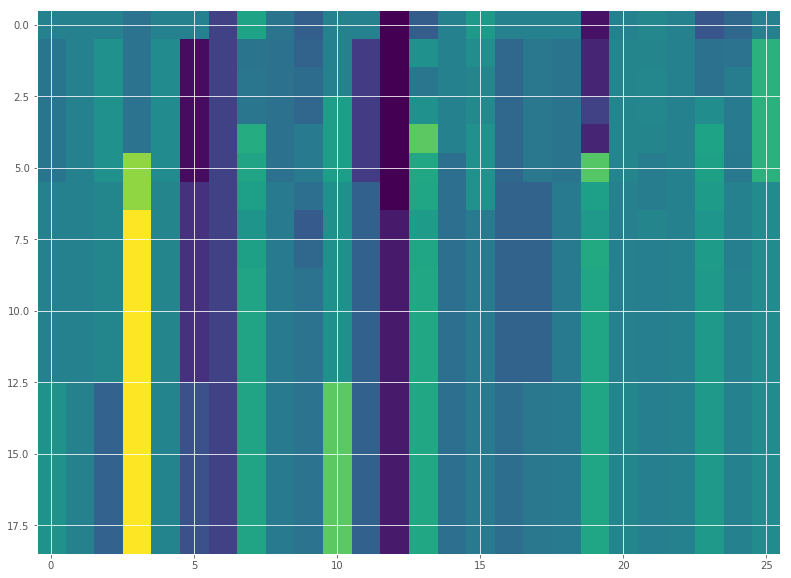

time: 277 ms


In [541]:
xtrain[0, :,0] #timestep 0 for first patient: 
# print(i)
# print(Y_test[i])
plt.imshow(xtest3[1])
#plt.imshow(arr[1])
plt.show()

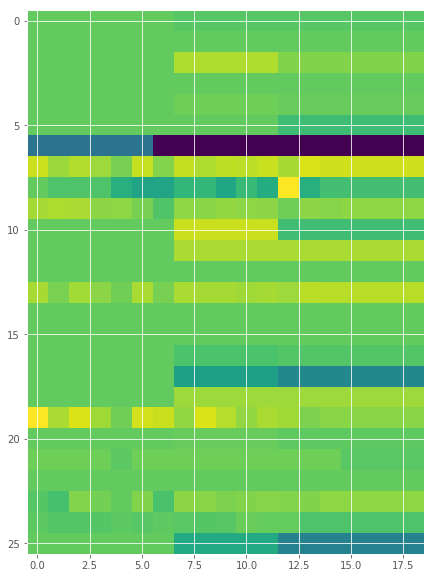

time: 192 ms


In [403]:
plt.imshow(arr[2])
plt.show()

In [401]:
arr[1].shape

(26, 19)

time: 2.33 ms


In [264]:
# #test_unstacked.fillna(value=0).count()#.count()#.sum()
# test_unstacked.shape[0]*test_unstacked.shape[1]

2013960

time: 2.54 ms


In [279]:
#noCat_df_train2['delta'].nunique()

2162

time: 16.6 ms


In [276]:
#test_unstacked.shape[0]/noCat_df_train2['icustay_id'].nunique()

14.571106094808126

time: 19.9 ms


In [265]:
#test_unstacked.isna().sum().sum()

1231122

time: 28 ms


In [266]:
#1231122/2013960

0.6112941667163201

time: 2.15 ms


### need to find the best resampling timepoint:
* get the % null values over a few resampling periods. 

In [186]:
len(grouper['value'].max())

879582

time: 1min 30s


In [232]:
grouper['value'].max()#.isna().sum()

icustay_id  delta            label          
200030.0    0 days 00:00:00  any_vasoactives         1.0
                             bands                absent
                             bicarbonate         2.99573
                             bun                  3.3673
                             calcium            0.765468
                             cancer_elix             0.0
                             chloride             4.7185
                             creatinine         0.693147
                             daily_sofa          1.09861
                             diasbp              4.21951
                             dobutamine              1.0
                             dopamine                0.0
                             epinephrine             0.0
                             glucose             5.47646
                             heartrate           4.62497
                             hemoglobin          2.40695
                             inr           

time: 1min 45s


In [230]:
# def percent_na(grouper):
#     grouped_max=grouper['value'].max()
#     sum_na=grouped_max.isna().sum()
#     total_val=grouped_max.count()
#     print("sumna:{}, total_values:{}, percent:{}".format(sum_na, total_val, 100*(sum_na/total_val)))


time: 5.21 ms


In [231]:
# percent_na(grouper)

sumna:5312, total_values:874271, percent:0.6075919251582175
time: 1min 49s
